## Motor correlates of prior
https://github.com/int-brain-lab/paper-brain-wide-map/blob/main/brainwidemap/meta/fig_motor_correlates_prior.py

In [1]:
'''
This code produces panels related to the motor correlates block of the
brain-wide-map paper. It references a npy file
(15f742e1-1043-45c9-9504-f1e8a53c1744_left.npy) containing an
example frame being used for illustration in one panel.
This file is assumed to be in your current working directory when
plotting the paw position on the example frame.

Cutting 7 behaviors during the inter-trial interval for all BWM
sessions takes about 1 h. One can use one core per lag variable
and compute in parallel. The lag variable specifies the start of
the inter-trial interval and we compute it for two lags.

See the code in the if __name__ == "__main__" block of this script.
'''

from one.api import ONE
import brainbox.behavior.wheel as wh
from brainbox.processing import bincount2D
from ibllib.atlas import AllenAtlas
from ibllib.atlas.regions import BrainRegions
from brainbox.io.one import SpikeSortingLoader
from brainbox.io.one import SessionLoader
from brainwidemap import bwm_query, load_trials_and_mask
import ibllib

import numpy as np
from pathlib import Path
from collections import Counter
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import random
import seaborn as sns
import matplotlib as mpl
import os
import traceback

/home/ines/miniconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/__init__.py:205: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


ONE Parameter files location: /home/ines/.one
Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/tmpcu72dtlm/cache.zip Bytes: 4916038


100%|██████████| 4.688299179077148/4.688299179077148 [00:01<00:00,  2.38it/s]
/home/ines/miniconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:22<00:00,  1.38it/s]


Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:08<00:00,  2.09s/it]


Loading bwm_query results from fixtures/2023_12_bwm_release.csv
Traceback (most recent call last):
  File "/tmp/ipykernel_15697/2034714795.py", line 266, in get_PSTHs_7behaviors
    qc = pd.read_csv(os.path.join(Path(__file__).parents[2], 'data_checks', 'qc_video_data.csv'))
NameError: name '__file__' is not defined

something off with a19c7a3a-7261-42ce-95d5-1f4ca46007ed
Traceback (most recent call last):
  File "/tmp/ipykernel_15697/2034714795.py", line 266, in get_PSTHs_7behaviors
    qc = pd.read_csv(os.path.join(Path(__file__).parents[2], 'data_checks', 'qc_video_data.csv'))
NameError: name '__file__' is not defined

something off with 0ac8d013-b91e-4732-bc7b-a1164ff3e445
Traceback (most recent call last):
  File "/tmp/ipykernel_15697/2034714795.py", line 266, in get_PSTHs_7behaviors
    qc = pd.read_csv(os.path.join(Path(__file__).parents[2], 'data_checks', 'qc_video_data.csv'))
NameError: name '__file__' is not defined

something off with e5c772cd-9c92-47ab-9525-d618b66a9b5d
Tra

/home/ines/miniconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.regions.BrainRegions is deprecated. Use iblatlas.regions.BrainRegions instead
  warnings.warn(warning_text, DeprecationWarning)


ZeroDivisionError: division by zero

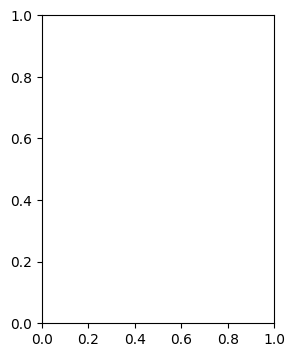

In [2]:


mpl.rcParams.update({'font.size': 10})

one = ONE(base_url='https://openalyx.internationalbrainlab.org',
          password='international')

# save results for plotting here
pth_res = Path(one.cache_dir, 'brain_wide_map', 'meta')
pth_res.mkdir(parents=True, exist_ok=True)

ba = AllenAtlas()
br = BrainRegions()

T_BIN = 0.02
Fs = {'left': 60, 'right': 150, 'body': 30}

# specify binning type, either bins or sampling rate; see cut_gahavior for defs
sr = {'licking': 'T_BIN', 'whisking_l': 60, 'whisking_r': 150,
      'wheeling': 'T_BIN', 'nose_pos': 60, 'paw_pos_r': 150,
      'paw_pos_l': 60}

blue_left = [0.13850039, 0.41331206, 0.74052025]
red_right = [0.66080672, 0.21526712, 0.23069468]
cdi = {0.8: blue_left, 0.2: red_right, 0.5: 'g', -1: 'cyan', 1: 'orange'}


def get_allen_info():
    '''
    Function to load Allen region info, e.g. region colors palette
    '''

    p = (Path(ibllib.__file__).parent /
         'atlas/allen_structure_tree.csv')

    dfa = pd.read_csv(p)

    # get colors per acronym and transfomr into RGB
    dfa['color_hex_triplet'] = dfa['color_hex_triplet'].fillna('FFFFFF')
    dfa['color_hex_triplet'] = dfa['color_hex_triplet'
                                   ].replace('19399', '19399a')
    dfa['color_hex_triplet'] = dfa['color_hex_triplet'] .replace('0', 'FFFFFF')
    dfa['color_hex_triplet'] = '#' + dfa['color_hex_triplet'].astype(str)
    dfa['color_hex_triplet'] = dfa['color_hex_triplet'
                                   ].apply(lambda x:
                                           mpl.colors.to_rgba(x))

    palette = dict(zip(dfa.acronym, dfa.color_hex_triplet))

    return dfa, palette


def generate_pseudo_blocks(
        n_trials,
        factor=60,
        min_=20,
        max_=100,
        first5050=90):
    """
    Generate a pseudo block structure
    Parameters
    ----------
    n_trials : int
        how many trials to generate
    factor : int
        factor of the exponential
    min_ : int
        minimum number of trials per block
    max_ : int
        maximum number of trials per block
    first5050 : int
        amount of trials with 50/50 left right probability at the beginning
    Returns
    ---------
    probabilityLeft : 1D array
        array with probability left per trial
    """

    block_ids = []
    while len(block_ids) < n_trials:
        x = np.random.exponential(factor)
        while (x <= min_) | (x >= max_):
            x = np.random.exponential(factor)
        if (len(block_ids) == 0) & (np.random.randint(2) == 0):
            block_ids += [0.2] * int(x)
        elif (len(block_ids) == 0):
            block_ids += [0.8] * int(x)
        elif block_ids[-1] == 0.2:
            block_ids += [0.8] * int(x)
        elif block_ids[-1] == 0.8:
            block_ids += [0.2] * int(x)
    return np.array([0.5] * first5050 + block_ids[:n_trials - first5050])


def find_nearest(array, value):
    '''
    Find the index of the array, such that the
    value is closest to that
    '''

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(
            value - array[idx - 1]) < math.fabs(value - array[idx])):
        return idx - 1
    else:
        return idx


def get_licks(dlc):
    '''
    define a frame as a lick frame if
    x or y for left or right tongue point
    change more than half the sdt of the diff
    '''

    licks = []
    for point in ['tongue_end_l', 'tongue_end_r']:
        for co in ['x', 'y']:
            c = dlc[point + '_' + co]
            thr = np.nanstd(np.diff(c)) / 4
            licks.append(set(np.where(abs(np.diff(c)) > thr)[0]))
    return sorted(list(set.union(*licks)))


def cut_behavior(eid, duration=0.4, lag=-0.6,
                 align='stimOn_times', stim_to_stim=False,
                 endTrial=False, query_type='remote', pawex=False):
    '''
    For a given session, cut segments of 7 behaviors

    param: eid: session eid
    param: align: in stimOn_times, firstMovement_times, feedback_times
    param: lag: time in sec wrt to align time to start segment
    param: duration: length of cut segment in sec
    '''
    sess_loader = SessionLoader(one, eid)

    # get wheel speed
    sess_loader.load_wheel()
    wheel = sess_loader.wheel

    # load whisker motion energy, separate for both cams
    sess_loader.load_motion_energy(views=['left', 'right'])
    left_whisker = sess_loader.motion_energy['leftCamera']
    right_whisker = sess_loader.motion_energy['rightCamera']

    # load DLC
    sess_loader.load_pose(views=['left', 'right'])
    dlc_left = sess_loader.pose['leftCamera']
    dlc_right = sess_loader.pose['rightCamera']

    # get licks using both cameras
    lick_times = []
    for dlc in [dlc_left, dlc_right]:
        r = get_licks(dlc)
        lick_times.append(dlc['times'][r])

    # combine left/right video licks and bin
    lick_times = sorted(np.concatenate(lick_times))
    R, times_lick, _ = bincount2D(lick_times, np.ones(len(lick_times)), T_BIN)
    lcs = R[0]

    # get paw position, for each cam separate
    if pawex:  # to illustrate paw position scatter on example frame
        paw_pos_r0 = np.array(list(zip(dlc_right['paw_r_x'],
                                       dlc_right['paw_r_y'])))
        paw_pos_l0 = np.array(list(zip(dlc_left['paw_r_x'],
                                       dlc_left['paw_r_y'])))
    else:
        paw_pos_r0 = (dlc_right['paw_r_x']**2 + dlc_right['paw_r_y']**2)**0.5
        paw_pos_l0 = (dlc_left['paw_r_x']**2 + dlc_left['paw_r_y']**2)**0.5

    ds = ('licking', 'whisking_l', 'whisking_r', 'wheeling',
          'nose_pos', 'paw_pos_r', 'paw_pos_l',
          'pleft', 'sides', 'choices', 'T')

    D = dict(zip(ds, [[] for x in ds])) #

    # continuous time series of behavior and stamps
    behaves = {'licking': [times_lick, lcs],
               'whisking_l': [left_whisker['times'],
                              left_whisker['whiskerMotionEnergy']],
               'whisking_r': [right_whisker['times'],
                              right_whisker['whiskerMotionEnergy']],
               'wheeling': [wheel['times'], abs(wheel['velocity'])],
               'nose_pos': [dlc_left['times'], dlc_left['nose_tip_x']],
               'paw_pos_r': [dlc_right['times'], paw_pos_r0],
               'paw_pos_l': [dlc_left['times'], paw_pos_l0]}

    trials, mask = load_trials_and_mask(one, eid)

    kk = 0

    for tr in range(1, len(trials) - 1):

        if not mask[tr]:
            continue
        # skip block boundary trials
        if trials['probabilityLeft'][tr] != trials['probabilityLeft'][tr + 1]:
            continue

        start_t = trials[align][tr] + lag

        if np.isnan(trials['contrastLeft'][tr]):
            side = 0  # right side stimulus
        else:
            side = 1  # left side stimulus

        D['sides'].append(side)

        if endTrial:
            D['choices'].append(trials['choice'][tr + 1])
        else:
            D['choices'].append(trials['choice'][tr])

        D['pleft'].append(trials['probabilityLeft'][tr])

        for be in behaves:
            times = behaves[be][0]
            series = behaves[be][1]
            start_idx = find_nearest(times, start_t)
            if stim_to_stim:
                end_idx = find_nearest(times, trials['stimOn_times'][tr + 1])
            else:
                if sr[be] == 'T_BIN':
                    end_idx = start_idx + int(duration / T_BIN)
                else:
                    fs = sr[be]
                    end_idx = start_idx + int(duration * fs)

            if (pawex and ('paw' in be)):  # for illustration on frame
                D[be].append([series[start_idx:end_idx, 0],
                              series[start_idx:end_idx, 1]])
            else:
                if start_idx > len(series):
                    print('start_idx > len(series)')
                    break
                D[be].append(series[start_idx:end_idx])

        D['T'].append(tr)
        kk += 1

    print(kk, 'trials used')
    return D


'''
####
batch processing
####
'''


def get_PSTHs_7behaviors(lag=-0.4):
    '''
    run once with lag = -0.6, -0.4
    '''

    df = bwm_query(one)
    eids = list(set(df['eid'].values))

    R = {}
    plt.ioff()
    for eid in eids:

        try:
            # only let sessions pass that have dlc passed for both side cams
            qc = pd.read_csv(os.path.join(Path(__file__).parents[2], 'data_checks', 'qc_video_data.csv'))
            qc = qc.loc[qc['eid'] == eid]
            qc_left = qc.loc[qc['label'] == 'left']
            qc_right = qc.loc[qc['label'] == 'right']
            if not (qc_left.iloc[0]['dlc'] and qc_right.iloc[0]['dlc']):
                continue

            R[eid] = PSTH_pseudo(eid, lag=lag, duration=0.4)
        except Exception as e:
            print(traceback.format_exc())
            print(f'something off with {eid}')
            continue

    s = (pth_res / f'behave7_{abs(lag)}.npy')
    np.save(s, R, allow_pickle=True)



'''
##########
plotting 
##########
'''

def Result_7behave(hists=False, save_df=False, bf = True):
    '''
    bar plot
    Used in overleaf motor-correlates figure
    '''

    behave7 = ['licking', 'whisking_l', 'whisking_r',
               'wheeling', 'nose_pos', 'paw_pos_r', 'paw_pos_l']

    infos = {'0.4': [[], '-0.4 s to stim'],
             '0.6': [[], '-0.6 to -0.2 s to stim']}

    if hists:
        fig = plt.figure(figsize=(5, 4))
        ax = plt.subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(3, 4))
        ax = plt.subplot(1, 1, 1)
    bwidth = 0.25

    cs = ['purple', 'orange']
    k = 0
    for t in ['0.4', '0.6']:
        s = (pth_res / f'behave7_{t}.npy')

        R = np.load(s, allow_pickle=True).flat[0]

        ms = ['dist', 'p', 'dom']

        c1 = [[x + '_' + y for y in ms] for x in behave7]
        c1flat = [item for sublist in c1 for item in sublist]
        c1flat.insert(0, 'eid')
        columns = c1flat

        r = []

        for eid in R:
            flag = False
            l = []
            if R[eid] == (None, None):
                continue
            else:
                for b in R[eid]:
                    if flag:
                        break
                    for j in R[eid][b]:

                        if not isinstance(j, str) and np.isnan(j):
                            flag = True
                            break
                        l.append(j)

                if flag:
                    continue
                else:
                    l.insert(0, eid)
                    r.append(l)

        df = pd.DataFrame(data=r, columns=columns)

        vals = [sum(df[x + '_p'] < 0.05) / len(df) for x in behave7]

        # check how many sessions have at least one modulated behavior
        ps = [x + '_p' for x in behave7]
        rr = [[float(df[df['eid'] == eid][y]) for y in ps]
              for eid in df['eid']]
        sigs = np.zeros(len(rr))
        sigs0 = np.zeros(len(rr))
        for i in range(len(rr)):
            if any(np.array(rr[i]) * len(behave7) < 0.05):
                sigs[i] = 1  # Bonferroni corrected
            if any(np.array(rr[i]) < 0.05):
                sigs0[i] = 1  # uncorrected

        df['atLeastOne_p<0.05'] = sigs0
        df['atLeastOne_p<0.05_BF'] = sigs

        sigs = sum(sigs) if bf else sum(sigs0)

        print(t, (f'{sigs} out of {len(rr)}'
              ' have at least one behavior modulated'))

        vals.append(float(sigs) / len(rr))
        infos[t][0].append(vals)

        ax.barh(np.arange(len(vals)) + k * 0.25, list(reversed(vals)),
                height=bwidth, label=infos[t][1], color=cs[k])

        if save_df:
            df.to_pickle(pth_res / 'ME.pkl')

        k += 1

    ax.axvline(x=0.05, linestyle='--', c='k')
    ax.set_yticks(range(len(behave7) + 1))
    ax.set_yticklabels(list(reversed(behave7 + ['at least one'])))
    ax.set_xlabel('fraction of sessions with p<0.05')
    print(f'{len(df)} sessions, {len(behave7)} behaviors \n'
          f'tested for block modulation \n')
    ax.set_ylabel('behavior')
    plt.tight_layout()
    plt.legend(ncol=1, frameon=False).set_draggable(True)

    if hists:
        ax = plt.subplot(1, 2, 2, sharey=ax)
        r2 = []
        cols2 = ['behavior', 'p']
        for eid in R:
            for b in R[eid]:
                r2.append([b, R[eid][b][1]])

        df = pd.DataFrame(data=r2, columns=cols2)

        sns.violinplot(y="behavior", x="p",
                       data=df, inner=None,
                       color=".8", split=True, meanline=True, bw=.01,
                       orient='h')

        plt.axvline(x=0.05, linestyle='--', c='gray',
                    label='p=0.05')

        plt.title('smoothed historgam of p-values')
        plt.tight_layout()



def PSTH_pseudo(eid, duration=0.4, lag=-0.4, plotting=True,
                control=False, query_type='remote', pawex=False):
    '''
    function to plot PSTH of whisking or licking in
    inter-trial interval, split by block,
    with pseudo-session control

    TO PLOT OVERLEAF MOTOR CORRELATE EXAMPLE,  
    paw example --> pawex = True
    eid = "15f742e1-1043-45c9-9504-f1e8a53c1744"
    param: control, boolean. If True, subdivide PSTH by choice
    '''

    if pawex:
        sr0 = {'paw_pos_l': 60}
    else:
        sr0 = sr

    D = cut_behavior(eid, lag=lag, duration=duration,
                     query_type=query_type)

    if len(Counter(D['pleft'])) != 3:
        print('no block structure')
        return None, None

    if plotting:
        plt.figure(figsize=(len(sr0) * 18 / 7, 6))
        Ax = [plt.subplot(2, len(sr0), q) for q in range(1, 2 * len(sr0) + 1)]

    Res = {}

    k = 0
    for motor in sr0:
        if sr0[motor] == 'T_BIN':
            xs = np.arange(duration / T_BIN) * T_BIN
        else:
            fs = sr0[motor]
            xs = np.arange(duration * fs) / fs

        xs = xs + lag

        D2 = {}

        null_d = []
        n_pseudo = 1000

        for i in range(n_pseudo):
            pb = generate_pseudo_blocks(len(D['pleft']))

            left_block = np.nanmean(
                (np.array(
                    D[motor])[
                    np.where(
                        np.array(pb) == 0.8)[0]]),
                axis=0)
            right_block = np.nanmean(
                (np.array(D[motor])[np.where(np.array(pb) == 0.2)[0]]), axis=0)

            D2[f'p_{i}_{i + 1}'] = abs(left_block - right_block)
            null_d.append(np.nanmean(D2[f'p_{i}_{i + 1}']))

            if plotting:

                if i == 0:
                    l1 = f'{n_pseudo} x pseudo'
                else:
                    l1 = '_nolegend_'

                Ax[k].plot(xs, left_block, label=l1, c='gray', linewidth=0.5)
                Ax[k].plot(xs, right_block, c='gray', linewidth=0.5)

        left_block = np.nanmean(
            (np.array(
                D[motor])[
                np.where(
                    np.array(
                        D['pleft']) == 0.8)[0]]),
            axis=0)
        right_block = np.nanmean(
            (np.array(
                D[motor])[
                np.where(
                    np.array(
                        D['pleft']) == 0.2)[0]]),
            axis=0)

        D2['left_right'] = abs(left_block - right_block)

        if control:

            ts = []
            for pl in [0.8, 0.2]:
                for ch in [1, -1]:

                    b1 = np.where(np.array(D['pleft']) == pl)[0]
                    b2 = np.where(np.array(D['choices']) == ch)[0]
                    s = np.array(list(set(b1).intersection(set(b2))))
                    ts.append(np.nanmean((np.array(D[motor])[s]), axis=0))

        # for each observation, get p value between distance
        # of real block psth curves and distances for the pseudo
        # session PSTH curves

        # save on which block is more whisking
        if (np.nanmean(left_block) - np.nanmean(right_block)) < 0:
            dom = 'pleft02'
        else:
            dom = 'pleft08'

        # average distances across observations
        samp = np.nanmean(D2['left_right'])

        # p value via percentile
        alpha = np.mean(np.array(null_d + [samp]) >= samp)

        # z-scored distance
        samp = (samp - np.mean(null_d)) / np.std(null_d)

        Res[motor] = [samp, alpha, dom]

        if plotting:

            Ax[k].plot(xs, left_block, label='p(l) = 0.8', c=blue_left)
            Ax[k].plot(xs, right_block, label='p(l) = 0.2', c=red_right)

            if control:

                cols = ['burlywood', 'coral', 'lime', 'teal']
                labs = ['pleft0.8_choice1', 'pleft0.8_choice-1',
                        'pleft0.2_choice1', 'pleft0.2_choice-1']

                for i in range(len(ts)):
                    Ax[k].plot(xs, ts[i], label=labs[i], c=cols[i])

            Ax[k].axvline(x=0, linestyle='--',
                          label='stimOn', color='pink')
            Ax[k].set_xlabel('time [sec]')
            Ax[k].set_ylabel(motor)
            Ax[k].set_title(f'{motor} \n'
                            f'dist={np.round(samp,3)} \n'
                            f'p={np.round(alpha,2)}', fontsize=15)

            if k == 0:
                Ax[k].legend().set_draggable(True)
#            ax1.axvspan(abs(lag)-0.6, abs(lag)-0.2, facecolor='pink',
#                        alpha=0.3)

            # Plot motor per trial

            cols = [cdi[x] for x in D['pleft']]
            ttype = list(Counter(D['pleft']).keys())

            Ax[k + len(sr0)].scatter(D['T'],
                                     np.nanmean(D[motor], axis=1),
                                     c=cols, s=1)

            Ax[k + len(sr0)].set_ylabel(f'{motor}')
            Ax[k + len(sr0)].set_xlabel('trial number')
            legend_elements = [
                Line2D(
                    [0],
                    [0],
                    marker='o',
                    color=cdi[y],
                    label=y,
                    markerfacecolor=cdi[y],
                    markersize=5,
                    linestyle='') for y in ttype]
            if k == 0:
                Ax[k + len(sr0)].legend(handles=legend_elements,
                                        loc='best').set_draggable(True)

        k += 1
        plt.tight_layout()

    if plotting:
        pa = one.eid2path(eid)
        n = '_'.join([str(pa).split('/')[i] for i in [4, 6, 7, 8]])
        plt.suptitle(f'{n}')
        plt.tight_layout()
#        plt.savefig('/home/mic/paper-brain-wide-map/'
#                    f'behavioral_block_correlates/figs/'
#                    f'7_behaviors0.4/{n}__{eid}.png')
        # plt.close()

    del D
    return Res

def paw_position_onframe(eid, ax=None, fig=None):
    '''
    load example video frame
    scatter plot average inter-trial-interval
    left paw position locations on top
    '''

    behave = 'paw_pos_l'

    img_file = os.path.join(os.getcwd(), f'{eid}_left.npy')
    r = np.load(img_file)[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    ax.imshow(r, cmap='gray', origin="upper")

    D = cut_behavior(eid, pawex=True)

    # get list of colors according to

    cols = [cdi[x] for x in D['pleft']]

    xs = [np.mean(u[0]) for u in D[behave]]
    ys = [np.mean(u[1]) for u in D[behave]]

    # plot in random order for better visibility
    # plot only every nth trial
    n = 1
    ids = np.arange(len(xs))
    random.shuffle(ids)
    xs = np.array(xs)[ids][::n]
    ys = np.array(ys)[ids][::n]
    cols = np.array(cols, dtype=object)[ids][::n]
    print(xs[:3], ys[:3])
    ax.scatter(xs, ys, c=cols, s=200, alpha=1, marker='x')

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker='x',
            color=cdi[y],
            label=f'p(l)={y}',
            markerfacecolor=cdi[y],
            markersize=8,
            linestyle='') for y in Counter(
            D['pleft']).keys()]

    plt.legend(handles=legend_elements, loc='lower right',
               prop={'size': 8}).set_draggable(True)

    plt.axis('off')
    plt.tight_layout()
    return D
    # continue here


if __name__ == "__main__":
    eid = '15f742e1-1043-45c9-9504-f1e8a53c1744'

    #  cut seven behaviors for all BWM sessions
    for lag in [-0.4, -0.6]:
        if not os.path.exists((pth_res / f'behave7_{abs(lag)}.npy')):
            get_PSTHs_7behaviors(lag = lag)

    # activate interactive plotting to see figures
    plt.ion()

    #  plot bar plot summarising fraction of sessions that 
    #  have sig motor correlates
    Result_7behave()
    
    paw_position_onframe(eid)
    
    # illustrate paw behavior per trial 
    PSTH_pseudo(eid,pawex=True)
    
    
       